# Ideas

* Backtesting: don't cross the spread, place limit orders in anticipation of a big price move
* Consider different time horizons via logsigs / conv layers with different kernels?
* Large spread should be a huge indicator. Also don't give up spread easily if it's huge
* Avoid very short holding peridos (smoothing, impact ideas)
* If short, don't sell on neutral signal, sell first on opposite signal (if nothing lost yet)
* Place limit orders: what is our anticipation? Expect large drop and rebound (and vice versa)?
* Which portion of the portfolio (Kelly, fixed proportion of your wealth)?
* Better smoothing of the strategy
* Incorporate information about market volatility
* Strategy should be based on my current inventory and pnl

# AB Test

* Ordering of the features: (ap, av, bp, bv) vs. (ap, bp, av, bv)
* Selectively remove features to check if they are significant

# To-Dos

* Never re-index / reset index: create method integrate that takes strategy and asset price paths and calculates pnl
* Proper scaling and transforms

# Fixed

* ewm at the beginning of the period is what?

In [54]:
import pandas as pd
from csv import writer
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Input, LSTM, Conv1D, Conv2D, Reshape, Dense, BatchNormalization, Dropout, concatenate
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [348]:
# size of the time-series slice used as input to the NN
WINDOW_SIZE = 100

# offset for the rolling windows used for training
OFFSET = 1

# size of the smoothing kernel used to generate labels
KERNEL_SIZE = 50

# center of mass for smoothing the strategy
COM = 10

# labels are quantized into -1, 0, 1 based on this threshold
LABEL_THRESHOLD = 1e-5

In [349]:
apcs = [f'ap_{i}' for i in range(10)]
avcs = [f'av_{i}' for i in range(10)]
bpcs = [f'bp_{i}' for i in range(10)]
bvcs = [f'bv_{i}' for i in range(10)]

keys = [x for items in zip(apcs, bpcs, avcs, bvcs) for x in items]
features = ['bid_diff_feature_1', 'ask_diff_feature_1']

# Data

In [350]:
pd.set_option('max_rows', 100)

In [351]:
df = pd.read_csv('_input/data/20210714_182011.csv')[:20000]
df.index = pd.to_datetime(df['timestamp'] * 1000 * 1000)
assert df.index.is_unique

df

,timestamp,best_bid_price,best_ask_price,estimated_delivery_price,index_price,mark_price,open_interest,settlement_price,change_id,ap_0,...,bp_7,bv_7,ap_8,av_8,bp_8,bv_8,ap_9,av_9,bp_9,bv_9
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-07-14 18:20:11.327,1626286811327,32863.0,32863.5,32871.25,32871.25,32861.28,341066510,31926.3,32987570399,32863.5,...,32857.0,7900.0,32871.5,32870.0,32856.5,2000.0,32872.0,42860.0,32856.0,2300.0
2021-07-14 18:20:11.592,1626286811592,32863.0,32863.5,32871.25,32871.25,32861.28,341066510,31926.3,32987570438,32863.5,...,32857.0,7900.0,32871.5,32870.0,32856.5,2000.0,32872.0,42860.0,32856.0,2300.0
2021-07-14 18:20:11.652,1626286811652,32863.0,32863.5,32871.25,32871.25,32861.28,341066510,31926.3,32987570451,32863.5,...,32857.0,7900.0,32871.5,32870.0,32856.5,2000.0,32872.0,42860.0,32856.0,2300.0
2021-07-14 18:20:11.814,1626286811814,32863.0,32863.5,32871.25,32871.25,32861.28,341066510,31926.3,32987570472,32863.5,...,32857.0,7900.0,32871.5,32870.0,32856.5,2000.0,32872.0,42860.0,32856.0,2300.0
2021-07-14 18:20:11.854,1626286811854,32863.0,32863.5,32871.25,32871.25,32861.28,341066510,31926.3,32987570482,32863.5,...,32856.5,2000.0,32871.5,32870.0,32856.0,2300.0,32872.0,42860.0,32855.0,3000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-14 19:04:04.574,1626289444574,32719.5,32720.0,32735.49,32735.49,32720.83,338331490,31926.3,32988531115,32720.0,...,32712.5,3000.0,32730.0,116340.0,32712.0,10000.0,32731.0,10.0,32711.5,162590.0
2021-07-14 19:04:04.731,1626289444731,32719.5,32720.0,32735.75,32735.75,32721.09,338331490,31926.3,32988531137,32720.0,...,32712.0,10000.0,32730.0,116340.0,32711.5,162590.0,32731.0,10.0,32711.0,2000.0
2021-07-14 19:04:04.827,1626289444827,32719.5,32720.0,32735.75,32735.75,32721.09,338331490,31926.3,32988531150,32720.0,...,32712.0,10000.0,32730.0,127740.0,32711.5,162590.0,32731.0,10.0,32711.0,2000.0


In [352]:
def prepare_df(df, k=KERNEL_SIZE):

    # diff time and asset price with lag=1 to remove trend
    df0 = df[['timestamp', 'best_bid_price', 'best_ask_price']].diff(1).rename(columns={'timestamp': 'timestamp_diff', 'best_bid_price': f'bid_diff_feature_1', 'best_ask_price': f'ask_diff_feature_1'})
    df0['timestamp_diff'] /= 1000.

    df1 = df[['best_bid_price', 'best_ask_price'] + keys]
    dfX = pd.concat([df1, df0], axis=1)

    # set prices as relative differences
    dfX[apcs] = dfX[apcs].sub(dfX['ap_0'], axis=0)
    dfX[bpcs] = -dfX[bpcs].sub(dfX['bp_0'], axis=0)

    # remove nans
    dfX = dfX[~dfX.isna().any(axis=1)]

    # rescale volumes
    l = 10.
    u = 1000000.
    dfX[avcs + bvcs] = (dfX[avcs + bvcs] - l) / (u - l)
    
    dfX['mid_price'] = (dfX['best_bid_price'] + dfX['best_ask_price']) / 2
    dfX['spread'] = dfX['best_ask_price'] - dfX['best_bid_price']

    # https://arxiv.org/pdf/1808.03668.pdf, p. 4
    dfX['m+'] = dfX['mid_price'].shift(-(k-1)).rolling(k).mean()
    dfX['m-'] = dfX['mid_price'].rolling(k).mean()
    dfX['y1'] = (dfX['m+'] - dfX['mid_price']) / dfX['mid_price']
    dfX['y2'] = (dfX['m+'] - dfX['m-']) / dfX['m-']

    dfX = dfX.iloc[k-1:-(k-1)]

    # reset index
    return dfX

dfX = prepare_df(df)
dfX[:10]

,best_bid_price,best_ask_price,ap_0,bp_0,av_0,bv_0,ap_1,bp_1,av_1,bv_1,...,bv_9,timestamp_diff,bid_diff_feature_1,ask_diff_feature_1,mid_price,spread,m+,m-,y1,y2
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-07-14 18:20:17.333,32869.5,32870.0,0.0,-0.0,0.01775,0.170992,2.5,1.0,0.00025,0.00999,...,0.00229,0.211,0.0,0.0,32869.75,0.5,32875.67,32865.72,0.00018,0.000303
2021-07-14 18:20:17.348,32869.5,32870.0,0.0,-0.0,0.01775,0.170992,2.5,1.0,0.00025,0.00999,...,0.00229,0.015,0.0,0.0,32869.75,0.5,32876.00,32865.85,0.00019,0.000309
2021-07-14 18:20:17.451,32869.5,32870.0,0.0,-0.0,0.01775,0.170992,3.5,1.0,0.00025,0.00999,...,0.00229,0.103,0.0,0.0,32869.75,0.5,32876.33,32865.98,0.00020,0.000315
2021-07-14 18:20:17.509,32869.5,32870.0,0.0,-0.0,0.01775,0.170992,3.5,1.0,0.00025,0.00999,...,0.00300,0.058,0.0,0.0,32869.75,0.5,32876.66,32866.11,0.00021,0.000321
2021-07-14 18:20:17.558,32869.5,32870.0,0.0,-0.0,0.01775,0.170992,2.0,1.0,0.00025,0.00999,...,0.00334,0.049,0.0,0.0,32869.75,0.5,32876.99,32866.24,0.00022,0.000327
2021-07-14 18:20:17.626,32869.5,32870.0,0.0,-0.0,0.01775,0.170992,2.0,1.0,0.00025,0.00999,...,0.00334,0.068,0.0,0.0,32869.75,0.5,32877.32,32866.37,0.00023,0.000333
2021-07-14 18:20:17.682,32869.5,32870.0,0.0,-0.0,0.01775,0.184002,1.0,1.0,0.00025,0.00999,...,0.00334,0.056,0.0,0.0,32869.75,0.5,32877.65,32866.50,0.00024,0.000339
2021-07-14 18:20:17.800,32869.5,32870.0,0.0,-0.0,0.01775,0.184002,1.0,1.0,0.00025,0.00999,...,0.00534,0.118,0.0,0.0,32869.75,0.5,32877.98,32866.63,0.00025,0.000345
2021-07-14 18:20:17.956,32869.5,32870.0,0.0,-0.0,0.01775,0.184002,2.0,1.0,0.00025,0.00999,...,0.00534,0.156,0.0,0.0,32869.75,0.5,32878.31,32866.76,0.00026,0.000351


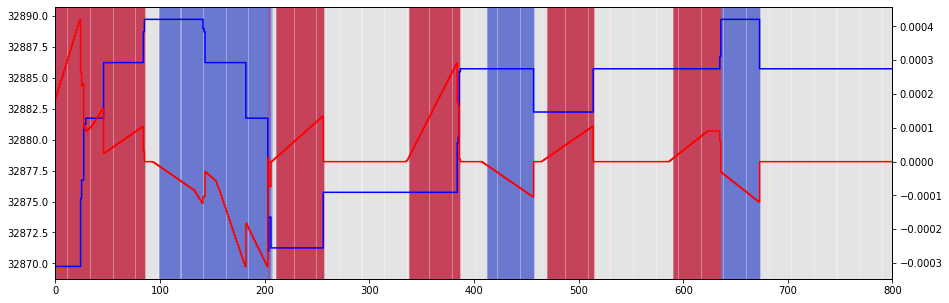

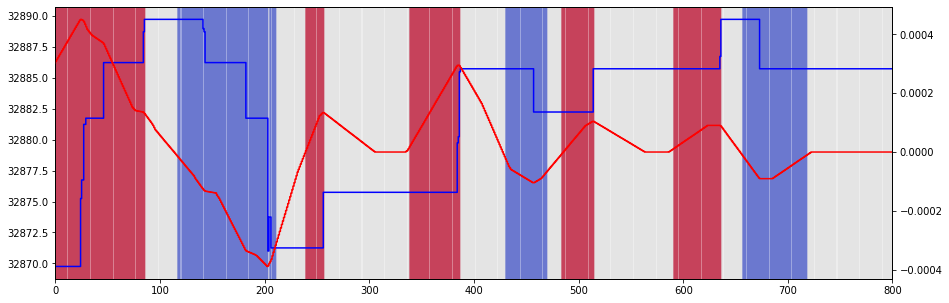

In [353]:
N0, N1 = 0, 800

for label in 'y1', 'y2':

    plt.figure(figsize=(15, 5))

    # colors
    cs = -1 + 1. * (dfX.iloc[N0:N1][label] > -LABEL_THRESHOLD) + 1. * (dfX.iloc[N0:N1]['y1'] > LABEL_THRESHOLD)
    cs = cs.to_numpy().reshape(1, -1)
    plt.pcolor(cs, cmap='coolwarm', alpha=0.5, linewidths=0)
    plt.yticks([])
    
    # price
    plt.twinx().step(np.arange(N1-N0), dfX.iloc[N0:N1]['mid_price'], c='b')

    # label
    plt.twinx().step(np.arange(N1-N0), dfX.iloc[N0:N1][label], c='r')


In [761]:
def split(df, offset, window_size):
    
    threshold = 5e-5
    print(len(df) - window_size, offset)
    
    I = np.array([x + np.arange(window_size) for x in np.arange(0, len(df) - window_size, offset)])
    
    # X1
    X1 = df[keys].to_numpy()[I]
    X1 = X1[:, :, :, np.newaxis]
    
    # X2
    X2 = df[features].to_numpy()[I]

    # y
    y = dfX.iloc[offset-1+window_size:len(df):offset]['y2'].to_numpy()
    y = -1 + 1. * (y >= -threshold) + 1. * (y >= threshold)
    
    # one-hot encoder
    enc = OneHotEncoder(sparse=False)
    y = enc.fit_transform(y.reshape(-1, 1))

    return X1, X2, y

In [763]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.15)

# Build model

In [358]:
def build_model(window_size):

    input_layer1 = Input(shape=(window_size, 40, 1))
    input_layer2 = Input(shape=(window_size, len(features)))

    x = Conv2D(16, kernel_size=(1, 2), strides=(1, 2), activation='relu')(input_layer1)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    
    x = Conv2D(16, kernel_size=(1, 2), strides=(1, 2), activation='relu')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    
    x = Conv2D(16, kernel_size=(1, 10), activation='relu')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)

    x = Reshape((window_size, -1))(x)

    x = concatenate([x, input_layer2])

    lstm_layer = LSTM(64)(x)
    bn_layer = BatchNormalization()(lstm_layer)
    dropout_layer = Dropout(0.8)(bn_layer)
    output_layer = Dense(3, activation='softmax')(dropout_layer)

    model = Model([input_layer1, input_layer2], output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [359]:
model = build_model(window_size=WINDOW_SIZE)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 100, 40, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 100, 20, 16)  48          input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 100, 20, 16)  1040        conv2d_63[0][0]                  
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 100, 20, 16)  1040        conv2d_64[0][0]                  
____________________________________________________________________________________________

In [360]:
cp_callback = ModelCheckpoint(filepath='_output/model.h5', monitor='val_accuracy', save_weights_only=True, save_best_only=True)
history = model.fit([X1_train, X2_train], y_train, epochs=30, batch_size=128, validation_split=0.15, callbacks=[cp_callback], verbose=2)

Epoch 1/30
112/112 - 48s - loss: 1.0304 - accuracy: 0.6147 - val_loss: 0.9578 - val_accuracy: 0.6036
Epoch 2/30
112/112 - 47s - loss: 0.8489 - accuracy: 0.6718 - val_loss: 0.9418 - val_accuracy: 0.5988
Epoch 3/30
112/112 - 47s - loss: 0.7826 - accuracy: 0.6888 - val_loss: 0.8360 - val_accuracy: 0.7050
Epoch 4/30
112/112 - 39s - loss: 0.7420 - accuracy: 0.7021 - val_loss: 0.8553 - val_accuracy: 0.4966
Epoch 5/30
112/112 - 39s - loss: 0.7116 - accuracy: 0.7111 - val_loss: 0.6731 - val_accuracy: 0.7311
Epoch 6/30
112/112 - 38s - loss: 0.6957 - accuracy: 0.7181 - val_loss: 0.6439 - val_accuracy: 0.7347
Epoch 7/30
112/112 - 38s - loss: 0.6644 - accuracy: 0.7325 - val_loss: 0.6584 - val_accuracy: 0.7287
Epoch 8/30
112/112 - 39s - loss: 0.6332 - accuracy: 0.7411 - val_loss: 0.6976 - val_accuracy: 0.7224
Epoch 9/30
112/112 - 39s - loss: 0.6268 - accuracy: 0.7476 - val_loss: 0.6130 - val_accuracy: 0.7295
Epoch 10/30
112/112 - 39s - loss: 0.5934 - accuracy: 0.7629 - val_loss: 0.5411 - val_accura

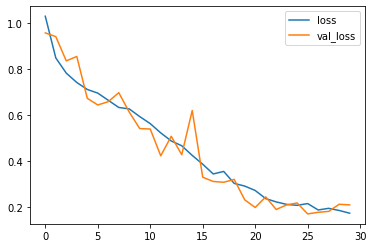

In [361]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [362]:
# load and evaluate best model

model.load_weights('_output/model.h5')

loss, accuracy = model.evaluate([X1_test, X2_test], y_test, verbose=0)

print(f"{'loss':15}{loss:7.4f}")
print(f"{'accuracy':15}{accuracy:7.4f}")

y_pred_num = np.argmax(model.predict([X1_test, X2_test]), axis=1)
y_test_num = np.argmax(y_test, axis=1)

precision, recall, fscore, support = precision_recall_fscore_support(y_pred_num, y_test_num)

print(f"{'precision':15}{' '.join(['{:7.2f}'.format(x) for x in precision])}")
print(f"{'recall':15}{' '.join(['{:7.2f}'.format(x) for x in recall])}")
print(f"{'fscore':15}{' '.join(['{:7.2f}'.format(x) for x in fscore])}")
print(f"{'support':15}{' '.join(['{:7}'.format(x) for x in support])}")


loss            0.1758
accuracy        0.9283
precision         0.93    0.93    0.92
recall            0.95    0.90    0.94
fscore            0.94    0.92    0.93
support            884    1292     795


# Backtest

In [770]:
def integrate(df, strategy_column='strategy', bid_column='best_bid_price', ask_column='best_ask_price'):
    
    df = df[[bid_column, ask_column, strategy_column]]
    df = df[~df.isna().any(axis=1)]
    
    strategy_diff = df[strategy_column].shift(1).fillna(0).diff(-1).fillna(0)
    
    # buy at best ask, sell at best bid
    money_diff = df[bid_column] * np.maximum(strategy_diff, 0)
    money_diff += df[ask_column] * np.minimum(strategy_diff, 0)
    
    # shift by one. at time zero, integral is always zero
    money_diff = money_diff.shift(1).fillna(0)
    money_account = np.cumsum(money_diff)
    
    portfolio_value = (df[strategy_column] * df[bid_column]).shift(1).fillna(0)
    pnl = money_account + portfolio_value
    
    retval_df = df[[bid_column, ask_column, strategy_column]].rename(columns={bid_column: 'bid', ask_column: 'ask', strategy_column: 'strategy'})
    retval_df['money'] = money_account
    retval_df['pnl'] = pnl
    
    return retval_df


In [771]:
def create_strategy(df):
    
    # load backtest dataset
    dfY = prepare_df(df)

    # predict returns
    X1, X2, _ = split(dfY, 1, WINDOW_SIZE)
    
    # predict returns
    ret_pred = model.predict([X1, X2])
    strategy = np.argmax(ret_pred, axis=1) - 1.

    # calculating ewm strategy
    retval_df = dfY[['timestamp_diff', 'best_bid_price', 'best_ask_price', 'y2']].copy()
    retval_df.loc[retval_df.index[WINDOW_SIZE:], ['p-', 'p0', 'p+']] = ret_pred
    retval_df.loc[retval_df.index[WINDOW_SIZE:], 'strategy'] = strategy.reshape(-1)
    retval_df.loc[retval_df.index[WINDOW_SIZE:], 'ewm_strategy_10'] = np.round(retval_df['strategy'].ewm(com=COM).mean())
    retval_df = retval_df[~retval_df.isna().any(axis=1)]
    
    retval_df.loc[:, ['money', 'pnl']] = integrate(retval_df, 'ewm_strategy_10')

    return retval_df

In [913]:
def add_strategy_to_plot(ax, strategy):
    
    y0, y1 = ax.get_ylim()
    height = (y1 - y0) * 0.1
    
    X = np.repeat(ax.lines[0].get_xdata().reshape(1, -1), 2, axis=0)
    Y = np.repeat([[0, height]], len(strategy), axis=0).T + y0 - 2 * height

    ax.pcolor(X, Y, strategy.to_numpy().reshape(1, -1), cmap='coolwarm', alpha=1., vmin=-1., vmax=1.)


def plot_strategy_and_pnl(df, strategy_column='strategy', bid_column='best_bid_price', ask_column='best_ask_price'):

    fig, ax = plt.subplots(figsize=(15, 10), nrows=2)
    df0 = df[~df.isna().any(axis=1)]

    ax[0].step(df0.index, df0[bid_column], c='b')
    add_strategy_to_plot(ax[0], df0[strategy_column])
    
    int_df = integrate(df, strategy_column)
    int_df = int_df[~int_df.isna().any(axis=1)]
    ax[1].step(df0.index, int_df['pnl'], c='r')
    
    add_strategy_to_plot(ax[1], df0[strategy_column])


In [ ]:
df = pd.read_csv('_input/data/20210714_182011.csv')[20000:]
df.index = pd.to_datetime(df['timestamp']*1000*1000)
assert df.index.is_unique

dff = create_strategy(df)
#dff.style.background_gradient(cmap='coolwarm', subset=(dff.index, ['y2', 'strategy', 'ewm_strategy_10']))

<ipython-input-913-3ed47cd26d21>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(X, Y, strategy.to_numpy().reshape(1, -1), cmap='coolwarm', alpha=1., vmin=-1., vmax=1.)
<ipython-input-913-3ed47cd26d21>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(X, Y, strategy.to_numpy().reshape(1, -1), cmap='coolwarm', alpha=1., vmin=-1., vmax=1.)


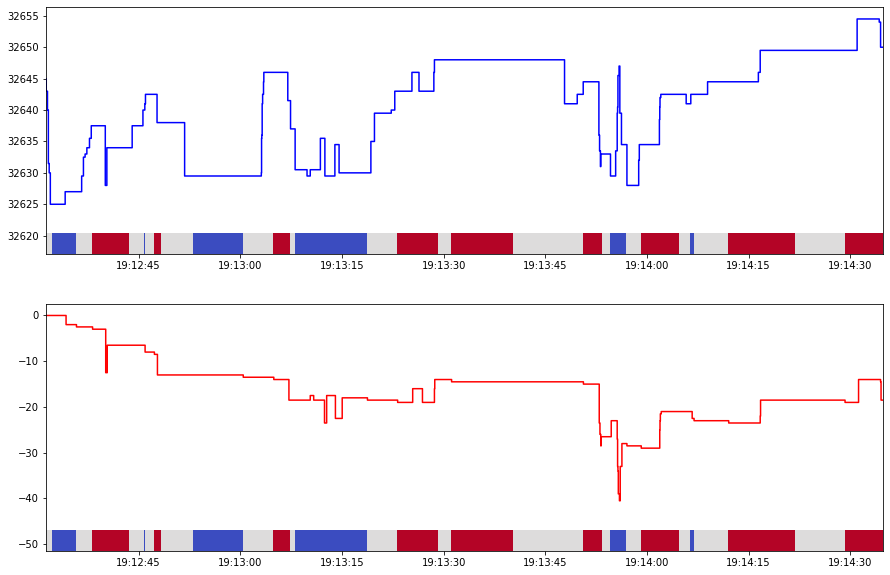

In [915]:
STEP = 1000
OFFSET = 5000
df0 = dff[OFFSET:OFFSET+STEP]
plot_strategy_and_pnl(df0, 'ewm_strategy_10')

<ipython-input-913-3ed47cd26d21>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(X, Y, strategy.to_numpy().reshape(1, -1), cmap='coolwarm', alpha=1., vmin=-1., vmax=1.)


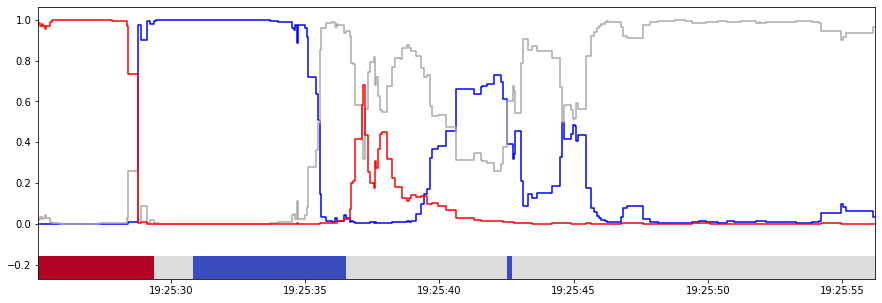

In [947]:
STEP = 200
OFFSET = 11300
df0 = dff[OFFSET:OFFSET+STEP]

fig, ax = plt.subplots(figsize=(15, 5))
ax.step(df0.index, df0['p-'], c='b')
ax.step(df0.index, df0['p0'], c='darkgray')
ax.step(df0.index, df0['p+'], c='r')
add_strategy_to_plot(ax, df0['ewm_strategy_10'])